# Neuron Model Tutorial

## Objectives:
- Use ODEs to build a Leaky Integrate and Fire Model
- Compare both models

## Install Packages

In [1]:
!pip install ./dependencies/numpy/*

Processing ./dependencies/numpy/numpy-1.24.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
numpy is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
!pip install ./dependencies/matplotlib/*

Processing ./dependencies/matplotlib/Pillow-9.5.0-cp311-cp311-manylinux_2_28_x86_64.whl
Processing ./dependencies/matplotlib/contourpy-1.0.7-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./dependencies/matplotlib/cycler-0.11.0-py3-none-any.whl
Processing ./dependencies/matplotlib/fonttools-4.39.3-py3-none-any.whl
Processing ./dependencies/matplotlib/kiwisolver-1.4.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./dependencies/matplotlib/matplotlib-3.7.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./dependencies/matplotlib/numpy-1.24.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./dependencies/matplotlib/packaging-23.0-py3-none-any.whl
Processing ./dependencies/matplotlib/pyparsing-3.0.9-py3-none-any.whl
Processing ./dependencies/matplotlib/python_dateutil-2.8.2-py2.py3-none-any.whl
Processing ./dependencies/matplotlib/six-1.16.0-py2.py3-none-any.whl
Pillow is already installed with the s

## Import Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Set up Helper Functions

In [ ]:
def my_GWN(pars, mu, sig, myseed=False):
    """
    Function that generates Gaussian white noise input

    Args:
    pars       : parameter dictionary
    mu         : noise baseline (mean)
    sig        : noise amplitute (standard deviation)
    myseed     : random seed. int or boolean
                 the same seed will give the same
                 random number sequence

    Returns:
    I          : Gaussian white noise input
    """

    # Retrieve simulation parameters
    dt, T = params['dt'], params['T']
    t = np.arange(0, T, dt)
    t_len = len(t)

    # Set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # Generate GWN
    # we divide here by 1000 to convert units to sec.
    I_gwn = mu + sig * np.random.randn(t_len) / np.sqrt(dt / 1000.)

    return I_gwn, t

## Section 1: A Return to the Hodgkin Huxley Equations

Biophysical modeling on neurons involves:
- knowing the input/output relationship you want to describe
- building the form your model is going to take
- testing to see if your model meets certain validity criteria when compared to real data

![modeling](./images/1_modeling.png)

When modeling a neuron, or even a patch of neuronal membrane, it is important to remember that in most cases, we are providing an externally sourced **current input** and measuring a **voltage output**. These values determine the **input/output relationship.**

Hodgkin Huxley models are a widely accepted form of biophysical model, due in large part because the model was built to reproduce the input-output function of an action potential from a squid giant axon. Hodgkin and Huxley successfully crafted a model with the right parameters to create model output that matched the data output. This comparison demonstrated the **validity** of the model, and is a classic way to show one's model is "good".

One particularly nice property of Hodgkin Huxley equations are that their form ended up reflecting empirically-based objects in the biological system. See the most general form of it below:

$$ I_{ext} = I_{C_m} + I_L + I_{Na} + I_K $$

Where $I_{ext}$ is the externally sourced current, $I_{C_m}$ is the capacitative current, $I_L$ is the leak current, and, most notably, $I_{Na}$ and $I_K$ are the sodium and potassium currents. The conceptual leap Hodgkin and Huxley made in this model was to introduce terms that reflected the contribution of sodium and potassium currents, separately. These terms correspond to empirically-based properties, the voltage gated sodium and potassium channels, in neurons. These properties can be manipulated both in the model and in real life (using sodium or potassium channel blockers), which makes this particular model powerful.

## Section 2: Building a Leaky Integrate and Fire Model

In the explanation above, we see how the question of "What generates an action potential?" is answered well with the HH model. However, what if we wanted to ask a different question?

Neurons produce many action potentials over time. We could then ask:
- Given a current input, how often does a neuron spike?
- Given a current input, how regularly or irregularly does a neuron spike?

Using a HH model to answer these questions could be computationally expensive to simulate due to the complex dynamics for evaluating the contributions of $I_{Na}$ and $I_K$.

Asking different questions and computational feasibility are major reasons why one would try to build a new neuron model that is simpler and easier to compute.

### Section 2.1: Building a "proto"-LIF Model

What can we do to make the HH model simpler? As a requirement, we want to largely maintain the relevant properties of the input/output function we need to answer our questions.

Let's look at an input/output function of a neuron.

![AP_features](./images/2_AP_features.svg)

$I(t)$ corresponds to input current, $V(t)$ corresponds to output voltage.

If we are trying to investigate action potential spike timing, like with our questions above, then perhaps all we need to do is produce a model that can recreate when the spike occurs. 

Do we need to recreate the shape of the spike to do this? Probably not. All we need to know is how to recreate the features of the voltage trace that don't include making the spike shape.

Our new model thus only needs to have the following properties:
- Use input current to depolarize the membrane voltage until a threshold ($V_{th}$) is reached
- Hyperpolarize back to resting state ($V_{rest}$), restarting the process

We can do this by using the HH model as a starting point.

The $I_{Na}$ and $I_K$ terms are necessary for the the action potential shape after reaching $V(th)$ and the hyperpolarization back to around resting state voltage potential at $V_{rest}$. What if we replaced these terms with a conditional statement that does exactly what we want? Our model may then be good enough to begin feasibly asking our questions.

Start with the HH model:

$$ I_{ext} = I_{C_m} + I_L + I_{Na} + I_K $$

Remove the $I_{Na}$ and $I_K$ terms!
$$ I_{ext} = I_{C_m} + I_L $$
$$ I_{ext} = C_m \frac{dV}{dt} + g_L(V-E_L) $$
Re-arrange the equation to view how the change in $V(t)$ over time is defined by a differential equation.
$$ C_m \frac{dV}{dt} = -g_L(V-E_L) + I_{ext} $$


**Think**: Look at $\frac{dV}{dt}$ above and do the following:
- What value would you need $V$ to be for $-g_L(V-E_L) = 0$?
- Assume $I_{ext} = 0$. What sign would $\frac{dV}{dt}$ be:
    - If $V > E_L$? 
    - If $V < E_L$?
- Assume $I_{ext} > 0$. When would $\frac{dV}{dt} = 0$ ? (**NOTE:** What are the students learning with this question?)

Based on this analysis, sketch and/or discuss what you think the solution trajectory of $V(t)$ looks like.

**Homework**: Find an analytic solution to this equation by using algebra and calculus to solve for $V(t)$.

Now that you've studied this equation, let's check to see if it does what we want it to do. Below we will use Forward Euler Integration to numerically solve (simulate) this differential equation.

---

### Section 2.2: Simulate a "proto"-LIF Model

Let's simulate what happens with this "proto"-LIF model using numerical integration.

This simulation uses the Forward Euler Integration method, which is discussed in the previous tutorial (see Section 2.2.2).

Below we will define three functions:
- A simulator function, `simulate_proto_LIF()` 
- A differential equation function, `dvdt_proto_LIF()`, that will be called within the simulator
- A parameter function to create a `dict` object containing all parameters, called `default_params()`

Read the comments within `simulate_proto_LIF()` to understand the input arguments, what steps are involved in the simulation, and the returned outputs of the function.

(**NOTE:** Update comments!)

In [4]:
def simulate_proto_LIF(params, I_inj): # Possibly make this into a helper function
    """Compute solution of the differential equation xdot=a*x with
    initial condition x0 for a duration T. Use time step dt for numerical
    solution.

    Args:
    a (scalar): parameter of xdot (xdot=a*x)
    x0 (scalar): initial condition (x at time 0)
    dt (scalar): timestep of the simulation
    T (scalar): total duration of the simulation

    Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
    """
    
    # Initialize parameters
    g_L = params['g_L']
    E_L = params['E_L']
    V_0 = params['V_0']
    C_m = params['C_m']
    dt  = params['dt']
    T   = params['T']
    
    # Initialize variables
    t = np.arange(0, T, dt)
    V = np.zeros_like(t)
    V[0] = V_0 # This is V at time t_0
    I_inj = I_inj * np.ones_like(t)
   
    # Step through system and integrate in time
    for k in range(1, len(t)):
        
        # for each point in time, compute xdot from x[k-1]
        dvdt = dvdt_proto_LIF(g_L, E_L, C_m, I_inj[k-1], V[k-1])

        # Update x based on x[k-1] and xdot
        V[k] = V[k-1] + dvdt*dt

    return V, t

def dvdt_proto_LIF(g_L, E_L, C_m, I_ext, V_val):
    return((1/C_m) * (-g_L * (V_val - E_L) + I_ext))

def default_params():  # Make into a helper function
    params = {'V_th': -55.0,    # mV
              'V_0': -75.0, # mV
              'tau_m': 10.0, 
              'g_L': 10.0,      # uS
              'V_reset': -75.0,     # mV
              'E_L': -75.0,     # mV
              'tref': 2.0,      # ms
              'T': 150.0,       # ms
              'dt': 0.1,        # ms
              'C_m': 100,
             }
    return params

**Visualize:** Let's now initialize our parameters, simulate $V(t)$ over time, and plot the simulation.

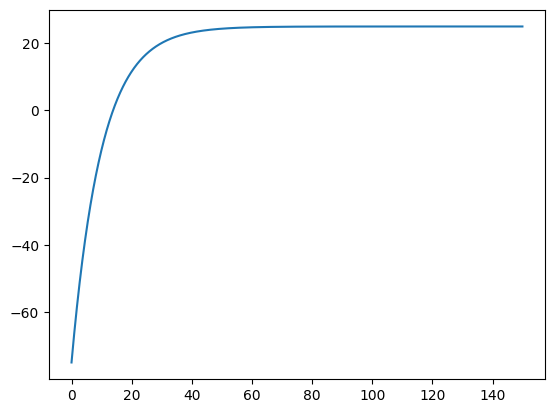

In [5]:
# Choose current magnitude and initialize parameters
I_ext = 1000 #pA
params = default_params()
# params['T'] = 10.0
# params['dt'] = 0.01

# Run simulation
solution, t = simulate_proto_LIF(params, I_ext)

# Plot simulation
plt.plot(t, solution)
plt.show()

**Think:** Why does the simulated voltage seem to approach an asymptote and go no further?

**Homework:** Use the proto-LIF differential equation to precisely solve for the steady state voltage that you see in the plot above.

### Section 2.3: Build a full LIF model

Based on the work above, our model is not done yet. It is missing the feature where the model hyperpolarizes back toward resting potential, $V_{rest}$. Let's divide both sides by $g_L$ and replace $\frac{C_m}{g_L}$ with $\tau_m$ ($\tau_m = \frac{C_m}{g_L}$).  We thus define the full LIF model as the following:
- $ \tau_m \frac{dV}{dt} = -(V-E_L) + \frac{I_{ext}}{g_L} $
- If $ V(t) = V_{th}$, then $ V(t + dt) = V_{reset} $

The conditional statement means that if $V(t)$ reaches a threshold value $V_{th}$, then at the next time step $V(t)$ will be set to $V_{reset}$. 

This is what makes the core of a functional Leaky Integrate and Fire Model.

Below we will define `simulate_LIF()` and add other important features to the simulator that makes this model more biologically plausible. This model will thus have the following features:
- Change in voltage based on the voltage of the neuron model and external input current (depolarization)
- Reset voltage when threshold potential is reached (hyperpolarization)
- Spike refractory period $\leftarrow$ (think about why this is included)

(**NOTE:** Think about this list, is it exhaustive?)

In [40]:
def simulate_LIF(params, I_inj): # Possibly make this into a helper function
    """Compute solution of the differential equation xdot=a*x with
    initial condition x0 for a duration T. Use time step dt for numerical
    solution.

    Args:
    a (scalar): parameter of xdot (xdot=a*x)
    x0 (scalar): initial condition (x at time 0)
    dt (scalar): timestep of the simulation
    T (scalar): total duration of the simulation

    Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
    """
    
    # Initialize parameters
    g_L = params['g_L']
    E_L = params['E_L']
    V_0 = params['V_0']
    C_m = params['C_m']
    dt  = params['dt']
    T   = params['T']
    
    V_th = params['V_th']
    V_reset = params['V_reset']
    tau_m = params['tau_m']
    tref = params['tref']
    
    # Initialize variables
    t = np.arange(0, T, dt)
    V = np.zeros_like(t)
    V[0] = V_0 # This is V at time t_0
    I_inj = I_inj * np.ones_like(t)
   
    # Step through system and integrate in time
    rec_spikes = []  # record spike times
    tr = 0.  # the count for refractory duration
    
    for k in range(1, len(t)):
        if tr > 0:  # check if in refractory period
            V[k-1] = V_reset  # set voltage to reset
            tr = tr - 1 # reduce running counter of refractory period

        elif V[k-1] >= V_th:  # if voltage over threshold
            rec_spikes.append(k)  # record spike event
            V[k-1] = V_reset  # reset voltage
            tr = tref / dt  # set refractory time

        # for each point in time, compute xdot from x[k-1]
        dvdt = dvdt_LIF(g_L, E_L, tau_m, I_inj[k-1], V[k-1])

        # Update x based on x[k-1] and xdot
        V[k] = V[k-1] + dvdt*dt

    return V, t, rec_spikes

def dvdt_LIF(g_L, E_L, tau_m, I_ext, V_val):
    return((1/tau_m) * (-(V_val - E_L) + I_ext/g_L))

**Visualize:** Let's now initialize our parameters, simulate $V(t)$ over time, and plot the simulation.

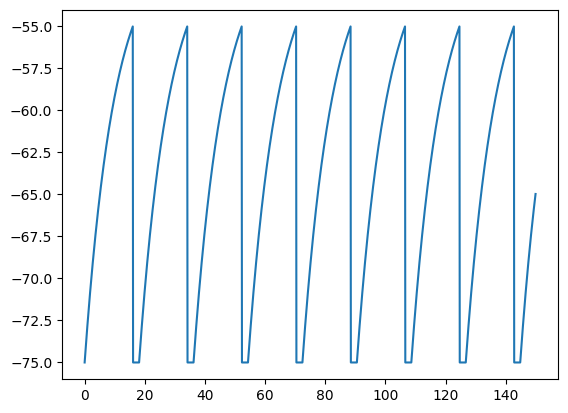

In [7]:
# Choose current magnitude and initialize parameters
I_ext = 250 #pA
params = default_params()
# params['T'] = 50.0


# Run simulation
solution, t, spike_times = simulate_LIF(params, I_ext)

# Plot simulation
plt.plot(t, solution)
plt.show()

**Think:** Are the three desired features of the neuron model present in this plot?

**Play:** Try different `I_ext` settings. 
- How does `I_ext` impact the number of spikes in this given amount of time? 
- What feature of the neuron model is directly impacted by increasing or decreasing `I_ext`?

You should notice that the variable `spike_times` is an output of our `simulate_LIF()` function. Let's print them below. 

**Think:** Do the spike times correspond to the "spikes" in the plot above? What must be the units of the spike time output from this simulation? (*Hint:* Use what you know about `dt` and `T`)

In [8]:
print(spike_times)

[162, 343, 524, 705, 886, 1067, 1248, 1429]


## Section 3: Describing an LIF Model's Input/Output Relationship

We now have a working LIF model that let's us explore the following questions mentioned above:
1. Given a current input, how often does a neuron spike?
2. Given a current input, how regularly or irregularly does a neuron spike?

### Section 3.1: Given a current input, how often does a neuron spike?

This is a question of spike frequency. Frequency is the rate at which an event occurs over a unit of time. This can be expressed as: 

$$ Frequency = \frac{"Events"}{"Time"} $$

An example of this is beats per minute in heart rate (or music!). ($f = \frac{\text{# of beats}}{\text{1 minute}}$)

In the case of neuron modeling, we are interested in spikes per second. ($f = \frac{\text{# of spikes}}{\text{1 second}}$)

Let's calculate a spike rate given some assumed input current, $I_{ext}$.

In [9]:
# Choose current magnitude and initialize parameters
I_ext = 250 #pA
params = default_params()
# params['T'] = 100.0


# Run simulation
solution, t, spike_times = simulate_LIF(params, I_ext)

The output of the simulation function is the voltage trace, the time range split into time steps, and an array of spike times.

To calculate frequency, we are interested in using the number of spikes over a given range of time in units of spikes per second. We will do so below.

In [10]:
# Calculate spike frequency
def spike_freq(spike_times, params):
    
    T = params['T']
    
    num_spikes = len(spike_times)
    T = T * (1 / 1000) # 1 second per 1000 milliseconds
    return num_spikes / T

In [11]:
freq = spike_freq(spike_times, params)
print('Frequency = %.2f spikes per second' % freq)

Frequency = 53.33 spikes per second


**Homework:** Is there a current $I_{ext}$ where the frequency should be zero? 
- How does this current relate to the steady state of the first equation in the LIF model?
- How does this steady state relate to $V_{th}$?

Now that we have the spike frequency function, we could play with the $I_{ext}$ input one at a time and see what frequencies result, but let's go a step further.

#### Section 3.1.1: F-I Curve

Below, let's produce an **F-I Curve**. This is a plot of frequencies as a result of a range of currents.

In [12]:
def IF_curve(params, I_max=1000, I_step=50):
    
    # Initialize current ranges
    I_range = np.arange(0, I_max, I_step)

    # Define for loop over different current values
    freq_rec = [] # Record frequency from each simulation

    for I_ext in I_range:

        # Run simulation
        solution, t, spike_times = simulate_LIF(params, I_ext)

        # Calculate frequency
        freq = spike_freq(spike_times, params)

        # Record frequency
        freq_rec.append(freq)
    
    return I_range, freq_rec

**Visualize:** Produce an F-I Curve.

In [13]:
# Initialize parameters
params = default_params()
# params['T'] = 100.0

I_max = 1000
I_step = 10

I_ext_range, frequencies = IF_curve(params, I_max, I_step)

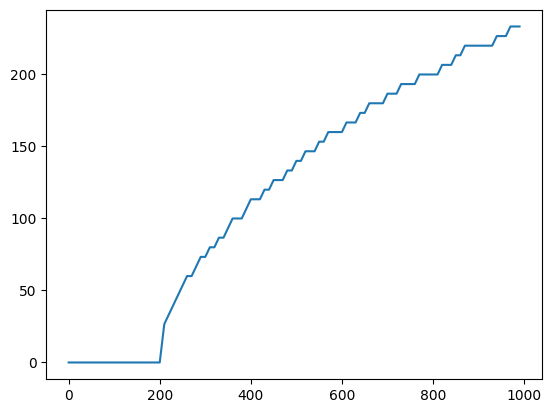

In [14]:
plt.plot(I_ext_range, frequencies)

**Play:** What happens if you increase the maximum range of the current, `I_max`, to be much larger?

**Play:** Try different values for the `tau_m` parameter. How does that impact the F-I curve?

A notable feature of this neuron is the current at which the neuron begins spiking, which is called the **Rheobase**. T can be observed in an F-I curve fairly easily. 

**Think:** What is the rheobase for this LIF neuron?

**Homework:** Plot and compare the F-I curves of neuron models with different settings of `tau_m`. 
- How does `tau_m` impact the rheobase of the neuron?

**Think:** Answer this section's question: Given a current input, how often does a neuron spike?

### Section 3.2: Given a current input, how regularly or irregularly does a neuron spike?

In the previous section, we quantified how often a neuron spikes as a measure of spike frequency and visualized how the external current $I_{ext}$ impacts this quantity. 

In this section we will explore the question of spike regularity. How can we quantify this?

To begin, we can see that a notable observable feature of a voltage trace is the inter-spike interval (ISI). This is the difference between one spike and the next.

![ISI](./images/3_ISI.svg)

Spike regularity relates to the distribution of ISI between all spikes in a voltage trace.

Let's consider 2 possibilities for regularity. 
- IF all of the ISIs would be the same, the neuron would be completely regular (clock-like)
- If all of the ISIs were random, the neuron would be irregular to some degree

If we plotted these possibilities as histograms, the histograms may look like the cartoon below:

![ISI_hist](./images/4_ISI_hist.png)

**Homework:** What if the ISIs were completely irregular?

(**NOTE:** This homework question may take research, consider as a mini-project)

To investigate spike regularity we can do these 3 things, which we'll explore in the following sections:
1. Measure all ISIs in a voltage trace
2. Visualize the ISIs in a histogram
3. Calculate a measure of regularity

#### Section 3.2.1: Measure Inter-Spike Interval and Visualize Histogram

First, let's get spike times from a LIF simulation.

In [15]:
# Simulate a LIF neuron to get spike times

# Choose current magnitude and initialize parameters
I_ext = 250 #pA
params = default_params()
# params['T'] = 50.0


# Run simulation
solution, t, spike_times = simulate_LIF(params, I_ext)

Let's calculate ISI. It can be summarized in the following equation

$ISI = spiketime_p - spiketime_{p-1}$

The difference in spike times between all pairs of spikes can be calculated using the `np.diff()` function.

In [16]:
ISI_array = np.diff(spike_times)

print('Calculated ISIs:', ISI_array)

Calculated ISIs: [181 181 181 181 181 181 181]


Now let's make a histogram of our ISIs. We can do so using the `plt.hist()` function

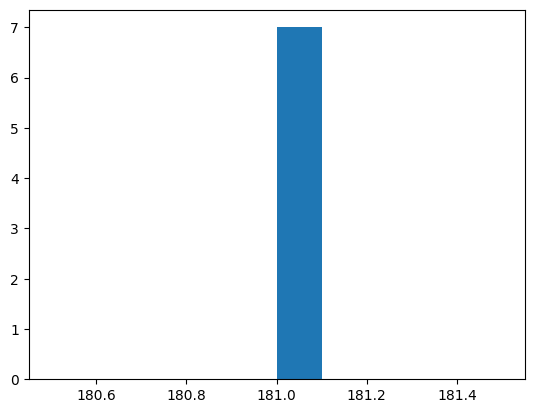

In [17]:
plt.hist(ISI_array)
plt.show()

**Think:** How regular is this LIF neuron output? Does this change when we try different $I_{ext}$ current inputs?

#### Section 3.2.2: Gaussian White Noise

The input current provided to our LIF neuron is noiseless and constant. This observation can lead to a new spin on our original question:

- How would noisy current impact the regularity of a neuron firing?

This question is relevant to biology as well. The input received by a neuron is rarely noiseless - it is noisy and time-varying. Let's next create a type of noisy current and use that as our input instead. Will this impact regularity?

Let's use a gaussian white noise (GWN) signal with mean $\mu$ and and noise $\sigma$ as input to our neuron model.

Use the helper function `my_GWN()` to produce a noisy current input with mean `mu` and variance `sigma`. Then plot the new current over time to visualize it.

The arguments of `my_GWN()` are `params`, `mu`, `sigma`.



(-300.0, 1001.0)

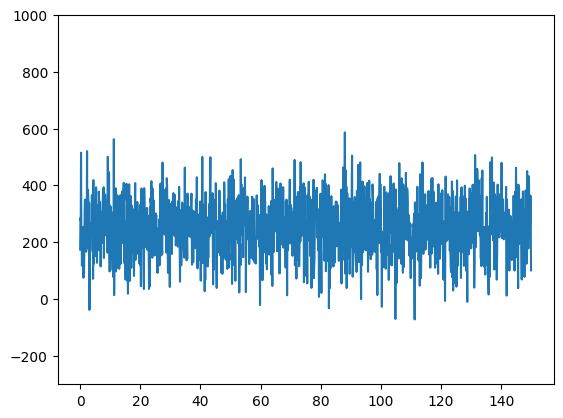

In [52]:
mu = 250
sigma = 1
I_ext, t = my_GWN(params, mu, sigma)
plt.plot(t, I_ext)
plt.ylim(-300, 1000 + sigma)

**Visualize:** Give the noisy current as input to an LIF model and observe the voltage trace output.

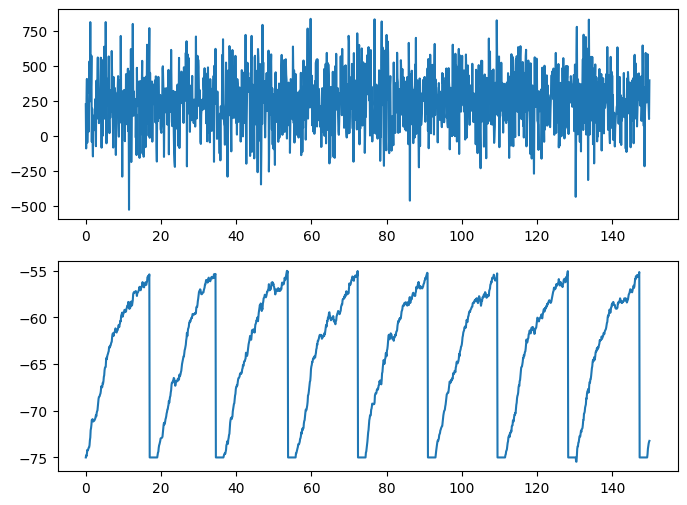

In [62]:
# Simulate a LIF neuron to get spike times

# Choose current magnitude and initialize parameters
params = default_params()
mu = 250
sigma = 2

# Produce Current
I_ext, t = my_GWN(params, mu, sigma)

# Run simulation
solution, t, spike_times = simulate_LIF(params, I_ext)

# Plot the current input and the voltage output
fig, ax = plt.subplots(2,1,figsize=(8,6),facecolor='white')
ax[0].plot(t, I_ext)
ax[1].plot(t, solution)

**Play:** Change `sigma` to different settings. What do you observe?


It seems that the spiking regularity could have an impact on regularity. Let's visualize this using a histogram.

Below we will
1. Run a LIF simulation 
    a. with a non-noisy current
    b. with a noisy current
2. Calculate ISI's for both sets of spike times
3. Plot both in histograms for comparison

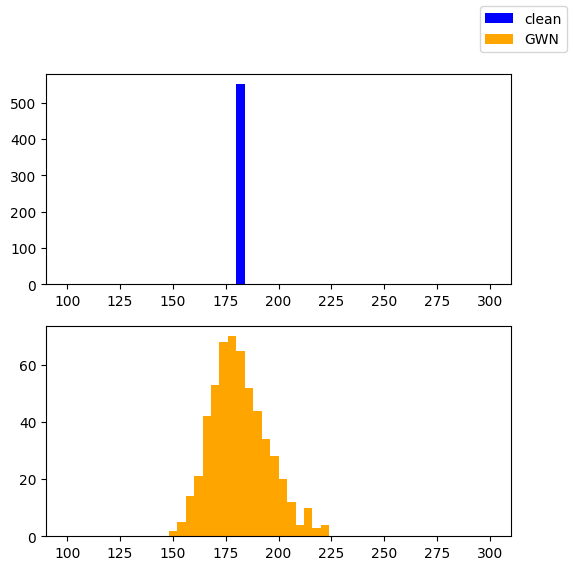

In [98]:
# Run LIF simulations for noisy and non-noisy currents

# Initialize parameters
params = default_params()
params['T'] = 10000

# Choose current input settings
I_ext = 250 # pA

mu = I_ext
sigma = 1

I_ext_GWN, t = my_GWN(params, mu, sigma)



# Run simulations

# Non-noisy current simulation
solution_clean, t, spike_times_clean = simulate_LIF(params, I_ext)

# Noisy current simulation
solution_GWN, t, spike_times_GWN = simulate_LIF(params, I_ext_GWN)

## Calculate ISIs

ISI_clean = np.diff(spike_times_clean)
ISI_GWN = np.diff(spike_times_GWN)

## Plot Histograms
bins = 50
ISI_range = (100, 300)
fig, ax = plt.subplots(2,1, figsize=(6,6), facecolor='white')
ax[0].hist(ISI_clean, bins=bins, range=ISI_range, label='clean', color='blue')
ax[1].hist(ISI_GWN, bins=bins, range=ISI_range, label='GWN', color='orange')
fig.legend()
plt.show()


**Play**: Change $\sigma$ and observe what happens to the ISIs.

#### Section 3.2.3: Quantify regularity with coefficient of variance

We've visualized when LIF model voltage output yields some degree of irregular spike times. But how do we quantify this irregularity?

(**NOTE**: Introduce CV math. As a bonus, think about poisson distribution as completely irregular)